# A2.1 Regresión logística y validación cruzada

En este trabajo, se analizará una base de datos histórica que contiene información sobre los pasajeros del Titanic, con el objetivo de predecir la probabilidad de supervivencia de cada uno de ellos utilizando un modelo de regresión logística. Esta técnica es adecuada, ya que la variable a predecir ("Survived") es binaria: 1 significa que el pasajero sobrevivió, y 0 que no lo hizo.

Variables utilizadas:

* Survived: Variable objetivo (0 = No sobrevivió, 1 = Sobrevivió).
* Pclass: Clase del pasajero (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase).
* Age: Edad del pasajero.
* SibSp: Número de hermanos o cónyuges a bordo.
* Parch: Número de padres o hijos a bordo.
* Fare: Tarifa pagada por el pasajero.
* Cabin_known: Indica si se conoce el número de camarote (1 = Sí, 0 = No).
* Sex_male: Género del pasajero (1 = Hombre, 0 = Mujer).
* Embarked_Q: Indica si el pasajero embarcó en el puerto Queenstown (1 = Sí, 0 = No).
* Embarked_S: Indica si el pasajero embarcó en el puerto Southampton (1 = Sí, 0 = No).
* Con estas variables, el modelo buscará patrones que permitan identificar qué tipo de pasajeros tuvieron mayor probabilidad de sobrevivir al hundimiento.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [2]:
df = pd.read_csv('DataTitanic_Processed.csv')
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_known,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,1


Es importante mencionar que dentro de las variables del dataset, la variable Pclass es una variable categórica, ya que representa la clase en la que viajaba el pasajero (Primera, Segunda o Tercera clase). Este tipo de variables no puede ser interpretado correctamente por un modelo de regresión logística si se trata como una variable numérica ordinal, ya que el modelo podría asumir una relación lineal entre las clases, lo cual no es adecuado en este caso.

Para resolver este problema, se procedió a realizar una transformación conocida como codificación one-hot o creación de variables dummies, lo que implica convertir cada categoría en una nueva columna binaria. De esta forma, el modelo podrá interpretar correctamente la pertenencia a cada clase sin inducir relaciones artificiales entre ellas.

Este paso es fundamental para asegurar que el análisis y las predicciones del modelo no se vean distorsionados por un tratamiento inadecuado de las variables categóricas.

In [3]:
dummyPclass = pd.get_dummies(df.Pclass, drop_first=True, dtype=int)
df = pd.concat([df, dummyPclass], axis=1)
df = df.drop(columns=['Pclass'], axis=1)

#Cambiar el nombre de las columnas
df.columns = ['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_known', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']
df.head()

,Survived,Age,SibSp,Parch,Fare,Cabin_known,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,1,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,0,1,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,1,0,1


Para evaluar el desempeño del modelo de regresión logística, se realizó una separación de los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%). Dado que la variable objetivo "Survived" es desbalanceada (hay más pasajeros que no sobrevivieron que pasajeros que sí), se verificó las proporciones al dividir los datos, con el fin de asegurar que la división de clases (sobrevivientes y no sobrevivientes) se mantuviera constante tanto en el conjunto de entrenamiento como en el de prueba.

In [4]:
print("Repartición de los datos originales")
print(df.Survived.value_counts())

X = df.drop('Survived', axis=1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nRepartición de los datos de entrenamiento")
print(y_train.value_counts())

print("\nRepartición de los datos de prueba")
print(y_test.value_counts())


Repartición de los datos originales
Survived
0    549
1    342
Name: count, dtype: int64

Repartición de los datos de entrenamiento
Survived
0    444
1    268
Name: count, dtype: int64

Repartición de los datos de prueba
Survived
0    105
1     74
Name: count, dtype: int64


Estas cifras reflejan que la proporción de clases se ha mantenido correctamente en los diferentes conjuntos, lo cual es fundamental para asegurar que el modelo aprenda y generalice adecuadamente.

Para continuar con el análisis, se procedió a entrenar un modelo de regresión logística utilizando la totalidad de los datos de entrenamiento. Este modelo servirá como la versión final, con la cual se generarán predicciones sobre el conjunto de prueba, permitiendo evaluar su desempeño y extraer conclusiones sobre su capacidad predictiva.

In [5]:
# Generar modelo de regresión logística
model = LogisticRegression(max_iter=1000, penalty=None,class_weight="balanced", random_state=0).fit(X_train,y_train)

Con el objetivo de medir el desempeño inicial del modelo de regresión logística, se aplicaron técnicas de validación cruzada sobre el conjunto de entrenamiento. La validación cruzada permite obtener una estimación más robusta de la exactitud del modelo, al evaluar su desempeño en múltiples particiones de los datos.

Para este análisis, se utilizaron dos enfoques:

Leave-One-Out Cross Validation (LOOCV): Esta técnica consiste en entrenar el modelo utilizando todos los datos de entrenamiento excepto una observación, que se deja fuera y se utiliza como validación. Este proceso se repite tantas veces como observaciones haya, cambiando en cada iteración la observación que se deja fuera.
Validación cruzada K-Fold: En este caso, los datos de entrenamiento se dividieron en K=5 subconjuntos o "folds". El modelo se entrena en 4 de estos subconjuntos y se valida en el restante, repitiendo el proceso hasta que cada fold haya sido utilizado como validación.

In [6]:
y_pred = model.predict(X_test)

# Medir la exactitud del modelo usando técnica de validación cruzada Leave-One-Out. 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(model, X_train, y_train, cv=loo)
print("Exactitud Leave-One-Out: ", scores.mean())

# Medir la exactitud del modelo usando técnica de validación cruzada K-Fold.
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = cross_val_score(model, X_train, y_train, cv=kf)
print("Exactitud K-Fold: ", scores.mean())

Exactitud Leave-One-Out:  0.7865168539325843
Exactitud K-Fold:  0.7879050526937851


Ambos resultados son consistentes entre sí, lo cual sugiere que el modelo tiene un comportamiento estable y que las métricas reflejan adecuadamente su capacidad de generalización sobre los datos de entrenamiento.

Con el modelo entrenado, se generó un vector de probabilidades para el conjunto de prueba, que representa la probabilidad estimada de que cada pasajero sobreviva.

In [7]:
#  Generar un vectorde probabilidades para los datos de prueba

y_pred_prob = model.predict_proba(X_test)[:,1]
print("Probabilidades de sobrevivir de 5 pasajeros de prueba")
print(y_pred_prob[0:5])

Probabilidades de sobrevivir de 5 pasajeros de prueba
[0.16749329 0.3293191  0.19045585 0.93297391 0.84177496]


Esto indica que los primeros tres pasajeros tienen bajas probabilidades de sobrevivir (menores al 50%), mientras que los pasajeros 4 y 5 presentan altas probabilidades de supervivencia (mayores al 80%).

Este comportamiento es consistente con lo esperado, ya que refleja que el modelo es capaz de diferenciar entre pasajeros con características asociadas a mayor riesgo y aquellos con condiciones más favorables para la supervivencia.

Para analizar el comportamiento del modelo al clasificar a los pasajeros del Titanic, se generó una matriz de confusión utilizando las predicciones sobre el conjunto de prueba. Esta matriz permite observar cuántos pasajeros fueron correctamente o incorrectamente clasificados como sobrevivientes o no sobrevivientes.

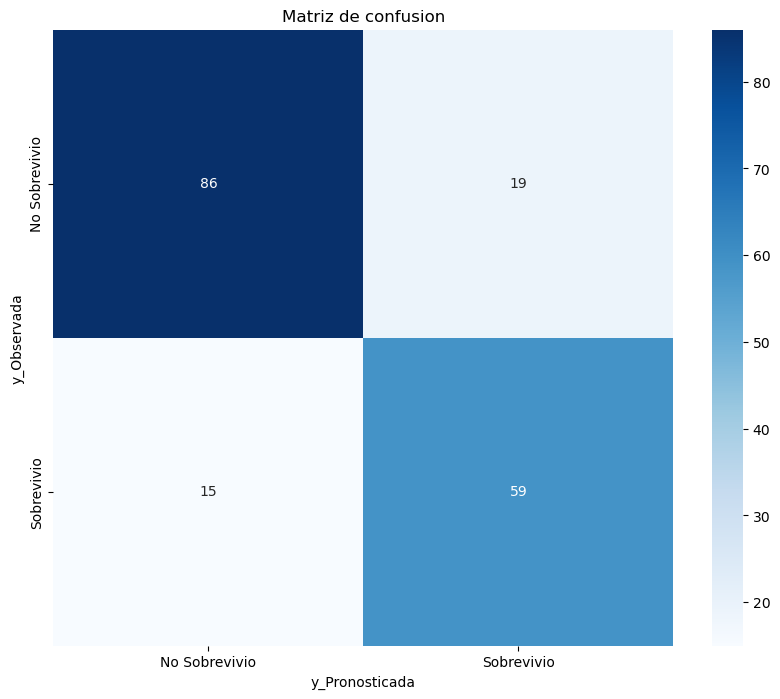

In [8]:
# La matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Dibujamos la matriz de confusion
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True,cmap = "Blues", xticklabels= ["No Sobrevivio", "Sobrevivio"], yticklabels= ["No Sobrevivio", "Sobrevivio"])
plt.ylabel("y_Observada")
plt.xlabel("y_Pronosticada")
plt.title("Matriz de confusion")
plt.show()

Con esta información se puede analizar el balance entre aciertos y errores, evaluando el desempeño general del modelo y observando su capacidad tanto para identificar correctamente a los pasajeros que no sobrevivieron, como para detectar correctamente a los que lograron sobrevivir. Además, es importante mencionar que los resultados son coherentes con lo esperado, debido a la proporción de clases, donde hay más pasajeros que no sobrevivieron. Esto provoca que el modelo tenga un mejor desempeño prediciendo a los pasajeros que no sobrevivieron, en comparación con aquellos que sí lograron sobrevivir.

Para evaluar el desempeño del modelo, se definieron tres umbrales de clasificación diferentes:

* Umbral 0.5: Es el valor comúnmente utilizado en problemas de clasificación binaria.
* Umbral 0.75: Exige mayor certeza para predecir que un pasajero sobrevivió.
* Umbral 0.25: Relaja el criterio para considerar que un pasajero sobrevivió.

Para cada uno de estos umbrales, se generaron las respectivas matrices de confusión, permitiendo calcular las siguientes métricas clave:

* Exactitud: Proporción de predicciones correctas sobre el total de observaciones.
* Sensibilidad: Proporción de pasajeros que realmente sobrevivieron y fueron correctamente identificados como sobrevivientes.
* Especificidad: Proporción de pasajeros que no sobrevivieron y fueron correctamente identificados como fallecidos.
* Precisión: Proporción de predicciones positivas que realmente correspondían a pasajeros que sobrevivieron.
* F1 Score: Promedio armónico entre precisión y sensibilidad, que permite evaluar el balance entre ambos indicadores.

Este análisis permite observar cómo cambia el comportamiento del modelo al modificar el umbral de decisión, lo cual es importante para ajustar el modelo dependiendo de si se quiere priorizar la detección de sobrevivientes (alta sensibilidad), minimizar los falsos positivos (alta especificidad), o buscar un equilibrio entre ambos (alto F1 Score), según los objetivos del análisis.

In [9]:
# Generar matriz de confusio, y exactitud, sensibilidad y especificidad del modelo antes 3 diferentes umbrales (0.5, 0.75, y 0.25)
def confusion_matrix_threshold(y_test, y_pred_prob, threshold):
    y_pred = np.where(y_pred_prob > threshold, 1, 0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return conf_matrix

thresholds = [0.25, 0.5, 0.75]
for threshold in thresholds:
    print("Matriz de confusión con umbral de probabilidad de ", threshold)
    print(confusion_matrix_threshold(y_test, y_pred_prob, threshold))
    
    y_pred = np.where(y_pred_prob > threshold, 1, 0)
    print("Exactitud: ", accuracy_score(y_test, y_pred))
    print("Sensibilidad: ", recall_score(y_test, y_pred))
    print("Especificidad: ", recall_score(y_test, y_pred, pos_label=0))
    print("Precision: ", precision_score(y_test, y_pred))
    print("F1: ", f1_score(y_test, y_pred))
    print("\n")
    
    

Matriz de confusión con umbral de probabilidad de  0.25
[[62 43]
 [ 7 67]]
Exactitud:  0.7206703910614525
Sensibilidad:  0.9054054054054054
Especificidad:  0.5904761904761905
Precision:  0.6090909090909091
F1:  0.7282608695652174


Matriz de confusión con umbral de probabilidad de  0.5
[[86 19]
 [15 59]]
Exactitud:  0.8100558659217877
Sensibilidad:  0.7972972972972973
Especificidad:  0.819047619047619
Precision:  0.7564102564102564
F1:  0.7763157894736842


Matriz de confusión con umbral de probabilidad de  0.75
[[97  8]
 [25 49]]
Exactitud:  0.8156424581005587
Sensibilidad:  0.6621621621621622
Especificidad:  0.9238095238095239
Precision:  0.8596491228070176
F1:  0.7480916030534351




**Umbral de 0.25**
Con un umbral bajo, el modelo tiende a predecir más pasajeros como sobrevivientes, lo que se refleja en una alta sensibilidad (90.54%) pero una baja especificidad (59.05%). Esto significa que el modelo detecta bien a los sobrevivientes, pero comete más errores al clasificar como sobrevivientes a quienes realmente no lo son. La precisión es moderada (60.91%), y la métrica F1 es de 72.83%, indicando un balance aceptable entre precisión y sensibilidad.

**Umbral de 0.5**
Este umbral representa el punto medio estándar en clasificación binaria. Aquí, la exactitud aumenta a 81.01%, con una sensibilidad de 79.73% y una especificidad de 81.90%, lo que sugiere un mejor equilibrio entre ambos tipos de errores. La precisión es de 75.64%, y la métrica F1 alcanza 77.63%, mostrando que este umbral ofrece un mejor balance entre la correcta clasificación de sobrevivientes y no sobrevivientes.

**Umbral de 0.75**
Al aumentar el umbral, el modelo se vuelve más conservador al clasificar como sobreviviente, lo que eleva la especificidad a 92.38% (es decir, predice mejor a quienes no sobrevivieron), pero reduce la sensibilidad a 66.22%, lo que implica que está fallando más en identificar a los sobrevivientes. La precisión mejora a 85.96%, pero la métrica F1 disminuye a 74.81% debido a la menor sensibilidad.

El umbral de 0.5 parece ofrecer el mejor equilibrio entre sensibilidad y especificidad, proporcionando una clasificación más confiable en términos generales, lo que se refleja en su f1 score mas alto que los otros umbrales.


Se va a generar la curva ROC para evaluar el desempeño del modelo de regresión logística en la clasificación de supervivencia de los pasajeros del Titanic. La curva ROC representa la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos a distintos umbrales de probabilidad.

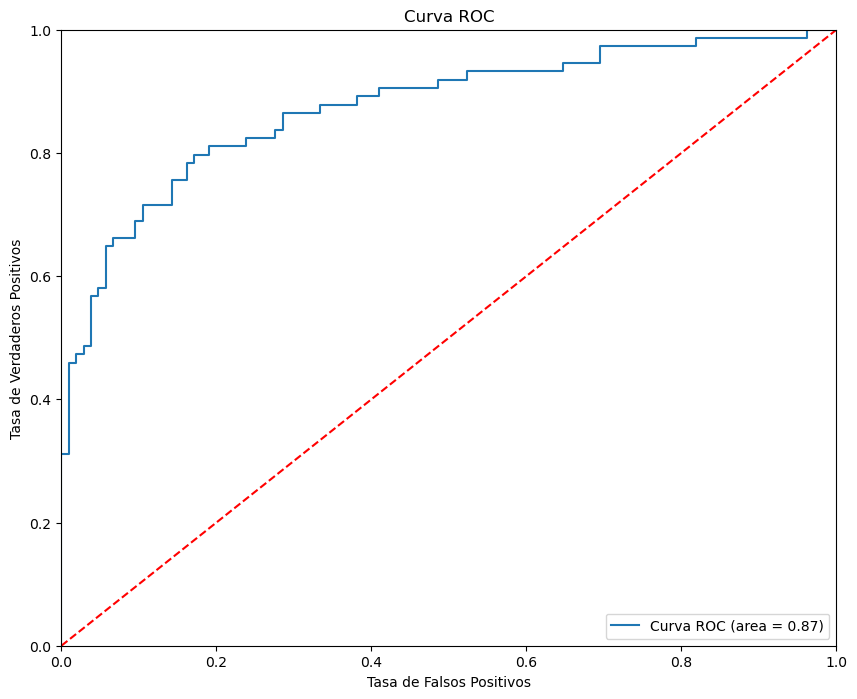

In [10]:
# Calcular la curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


En la gráfica obtenida, se observa que el modelo tiene un buen desempeño, con un área bajo la curva (AUC) de 0.87. Este valor indica que el modelo logra una adecuada discriminación entre pasajeros que sobrevivieron y aquellos que no lo hicieron. Un AUC de 0.87 sugiere que, en promedio, el modelo asigna una mayor probabilidad de supervivencia a los pasajeros que realmente sobrevivieron en comparación con los que no lo hicieron.

La línea roja discontinua representa la línea de referencia de un clasificador aleatorio (AUC = 0.5), mientras que la curva azul muestra el rendimiento real del modelo, evidenciando su capacidad predictiva superior al azar.

Se mostraran los coeficientes obtenidos en la regresión logística que representan el impacto de cada variable en la probabilidad de que un pasajero haya sobrevivido al Titanic. Un coeficiente positivo indica que un aumento en esa variable incrementa la probabilidad de supervivencia, mientras que un coeficiente negativo sugiere una disminución en dicha probabilidad.

In [11]:
# Mostrar los coeficientes del modelo de regresión logística
print("Coeficientes del modelo de regresión logística")
print('Intercepto =', model.intercept_)
coeficientes = pd.DataFrame(model.coef_, columns=X.columns)
print(coeficientes.transpose())



Coeficientes del modelo de regresión logística
Intercepto = [3.09450244]
                    0
Age         -0.031072
SibSp       -0.292115
Parch       -0.182307
Fare         0.003486
Cabin_known  1.232930
Sex_male    -2.671632
Embarked_Q  -0.292065
Embarked_S  -0.541033
Pclass_2     0.333534
Pclass_3    -0.735069


De acuerdo a los coeficientes, se pueden interpretar lo siguiente:

* Sexo masculino (Sex_male = -2.6716): Ser hombre reduce considerablemente la probabilidad de supervivencia, lo cual concuerda con la política de evacuación de "mujeres y niños primero".
* Segunda clase (Pclass_2 = 0.3335): Los pasajeros de segunda clase tuvieron una probabilidad ligeramente mayor de sobrevivir en comparación con la primera clase.
* Tercera clase (Pclass_3 = -0.7351): Los pasajeros de tercera clase tenían una probabilidad significativamente menor de supervivencia en comparación con los de primera clase, lo que refleja las desigualdades en el acceso a los botes salvavidas.
* Tarifa del boleto (Fare = 0.0035): Un aumento en la tarifa está asociado con una mayor probabilidad de supervivencia. Esto podría indicar que los pasajeros en clases más altas tenían más acceso a los botes salvavidas.
* Edad (Age = -0.0311): A medida que la edad aumenta, la probabilidad de supervivencia disminuye ligeramente. Esto sugiere que los pasajeros más jóvenes tenían mayor probabilidad de sobrevivir.


**Firma de honor:** "Doy mi palabra que he realizado esta actividad con integridad académica" - Daniel Matthieu Potes Lesoinne #584678